TODO: try to call the function from HarrisWolpertandPursuit:
    -expectation
    -variance
    -power
    -A_pow
    -pow_fast
TODO:

## 1. Asymmetrical bang-bang solutions and pursuit

When $U_+ != U_-$

When solving the following differencial equation:

$$
\dfrac{d\dot{x}(t)}{dt} = -\frac{1}{\tau}\cdot\dot{x}(t)+u(t)
$$

In asymmetrical bang-bang, rather than symmetrical bang-bang having only one solution, the equation have several solutions.

Here we will solve this equation in case of an asymmetrical bang-bang : listing all the solutions and sort out which one is the most efficient in term of accuracy and movement time.

On $\intervalle{0}{\rho\cdot T}: \dfrac{d\dot{x}(t)}{dt} = -\dfrac{1}{\tau}\cdot\dot{x}(t)+U_+$  
  
We find:  $\dot{x}(t) = U_+\cdot\tau\left (1-e^{- \frac{t}{\tau}} \right )$ and so : $x(t) = U_+\cdot\tau\left [t-\tau\left(1-e^{- \frac{t}{\tau}} \right )\right]$

On $\intervalleof{\rho\cdot T}{T}: \dfrac{d\dot{x}(t)}{dt} = -\dfrac{1}{\tau}\cdot\dot{x}(t)+U_-$  
  
We find:  $\dot{x}(t) = U_-\cdot\tau\left (1-e^{\frac{T-t}{\tau}} \right ) + v\cdot e^{\frac{T-t}{\tau}}$ and so : $x(t) = x_T +v\cdot T- U_-\cdot\tau\left [T-t+\tau\left(1-e^{\frac{T-t}{\tau}} \right )\right] + v\cdot \tau\left(1-e^{\frac{T-t}{\tau}} \right )$

On $\intervalleoo{T}{+\infty}: \dfrac{d\dot{x}(t)}{dt} = -\dfrac{1}{\tau}\cdot\dot{x}(t)+U_{\infty}$  
  
We find:  $U_{\infty} = \dfrac{1}{\tau}\cdot v$ since $\forall t \in \intervalleoo{T}{+\infty}, \dot{x}(t) = v$ (and $\ddot{x}(t) = 0$) and so : $x(t) = v\cdot \left ( t - T \right)+x_T+v\cdot T$

Then, we use the continuity of the velocity at time $\rho\cdot T$ to find relations between $U_+$, $U_-$ and $\rho$.  
    
$U_+ = U_- \cdot \dfrac{1-e^{\frac{\left(1-\rho \right)T}{\tau}}}{1-e^{-\frac{\rho T}{\tau}}}$  
  
With the continuity of the position at time $\rho\cdot T$, we find relations between $U_-$ and $\rho$, and between $U_+$ and $\rho$ thanks to the previous formula.  

$U_- = \dfrac{1}{\tau} \cdot \dfrac{\left (x_T + v\cdot T+v\cdot\tau \right)\left (1-e^{-\frac{\rho T}{\tau}}\right)-v\cdot\rho\cdot T \left (1-e^{\frac{\left(1-\rho \right)T}{\tau}} \right )}{T-\left (1-\rho\right)T e^{-\frac{\rho T}{\tau}}-\rho T e^{\frac{\left(1-\rho \right)T}{\tau}}}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# import all the functions from HarrisWolpertandPursuit.py et PlotFunctions.py
from HarrisWolpertandPursuit import * 
from PlotFunctions import *


In [3]:
tau = 0.013    # a plant parameter
xT = 10    #values at time T of both position and velocity
dt = 0.0001    # timestep of the algorithm (s)
t_T = .05    # movement period (s)
t_R = .05    # post-movement period (s)
k = 0.00001   # coefficient of intensity of the multiplicative noise
T = int(t_T/dt)    
R = int(t_R/dt)    
time = np.linspace(0, t_T + t_R, R+T+1)
time_ms = time*1000
x0 = np.array([5, 20])    # initial values of both position and velocity of the target
v0 = 20    # velocity of the target

In [4]:
# definition of A and B : creating two arrays

A = np.zeros((2,2))
B = np.zeros(2)

for i in np.arange(2):
    for j in np.arange(i,2):
        fact(n = j-i) # calling the function fact(n) from HarrisWolpertandPursuit
        A[i,j] = dt**(j-i)/fact(j-i)
A[1, 1] = 1-dt/tau
B[1] = dt


In [5]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))

def A_pow(A):
    A_pow_array = np.zeros((T+R+1,2,2))

    for i in np.arange(T+R+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A)

def pow_fast(n):
    return A_pow_array[n]

ci0_array = np.zeros(T+R+1)
ci1_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0]
    ci1_array[i] = (pow_fast(i).dot(B))[1]
    
#ci2_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci2_array[i] = (pow_fast(i).dot(B))[2]
    
#ci3_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci3_array[i] = (pow_fast(i).dot(B))[3]

ci = np.array([ci0_array, ci1_array])


In [6]:
def expectation(u, t):
    """Computation of the expectation of the state vector at time t, given u
    """
    if t == 0:
        return x0
    else:
        return pow_fast(t).dot(x0)+(ci[:,0:t]*np.flipud(u[0:t])).sum(axis = 1)


In [7]:
def variance(u, t):
    """Computation of the variance of the state vector at time t, given u
    """
    return k*(np.flipud(ci0_array[0:t]**2)*u[0:t]**2).sum()

In [8]:
n = 100 # number of rho's values

In [9]:
rho = np.linspace(0.5, 0.999, n) # rho's tested values

In [10]:
Umoins = 1/tau*((xT+v0*(t_T+tau))*(1-np.exp(-rho*t_T/tau))-v0*rho*t_T*np.exp((1-rho)*t_T/tau)) \
            / (t_T-(1-rho)*t_T*np.exp(-rho*t_T/tau)-rho*t_T*np.exp((1-rho)*t_T/tau))

In [11]:
Uplus = (1-np.exp((1-rho)*t_T/tau))/(1-np.exp(-rho*t_T/tau))*Umoins+1/tau*v0*np.exp((1-rho)*t_T/tau)/(1-np.exp(-rho*t_T/tau))

In [12]:
#paramètres de position de l'oeil au temps t0
Umoins = 1/tau*((xT-x0[0]+v0*(t_T+tau)-0*x0[1]*(rho*t_T+tau))*(1-np.exp(-rho*t_T/tau))-rho*t_T*(v0*np.exp((1-rho)*t_T/tau)-0*x0[1]))/(t_T-(1-rho)*t_T*np.exp(-rho*t_T/tau)-rho*t_T*np.exp((1-rho)*t_T/tau))

Uplus = (1-np.exp((1-rho)*t_T/tau))/(1-np.exp(-rho*t_T/tau))*Umoins+1/tau*(v0*np.exp((1-rho)*t_T/tau)-0*x0[1])/(1-np.exp(-rho*t_T/tau))


In [13]:
u = np.zeros((n-1, T+R+1))

for i in np.arange(n-1):
    rhoT = int(T*rho[i])
    u[i,:] = np.concatenate((Uplus[i]*np.ones(rhoT), Umoins[i]*np.ones(T-rhoT), 1/tau*v0*np.ones(R+1)))


In [14]:
position = np.zeros((n-1, T+R+1))
velocity = np.zeros((n-1, T+R+1))

for i in np.arange(n-1):
    for j in np.arange(T+R+1):
        #expectation(u[i,:], t = j) # calling the function expectation from HarrisWolpertandPursuit
        mean = expectation(u[i,:], j)
        position[i,j] = mean[0]
        velocity[i,j] = mean[1]


In [15]:
variancev = np.zeros((n-1, T+R+1))

for i in np.arange(n-1):
    for j in np.arange(T+R+1):
        variancev[i,j] = variance(u[i,:], j)

Text(0,0.5,'u')

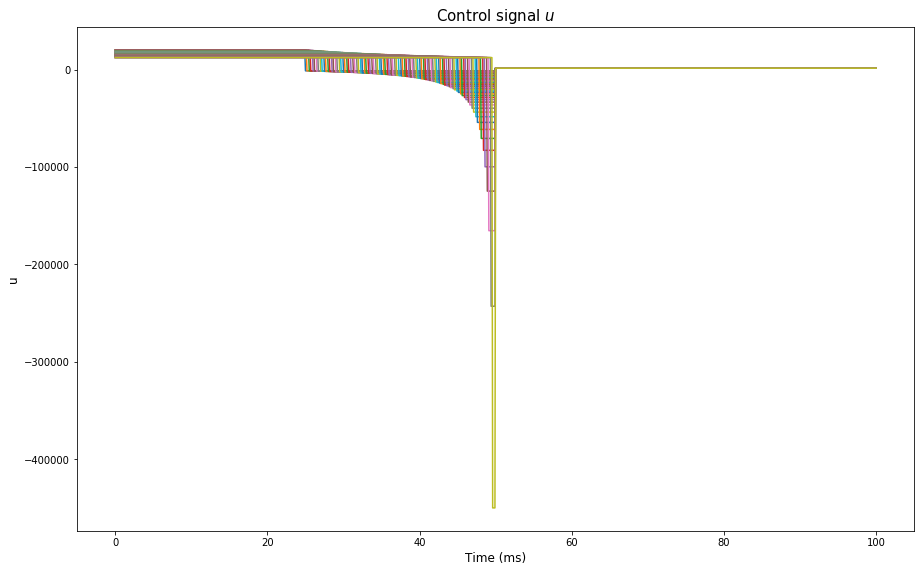

In [20]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
for i in np.arange(n-1):
    ax.plot(time_ms, u[i,:])

#print(u[i,:])
#print(len(u[i,:]))
    
ax.set_title('Control signal $u$', fontsize = 15)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('u', fontsize=12)

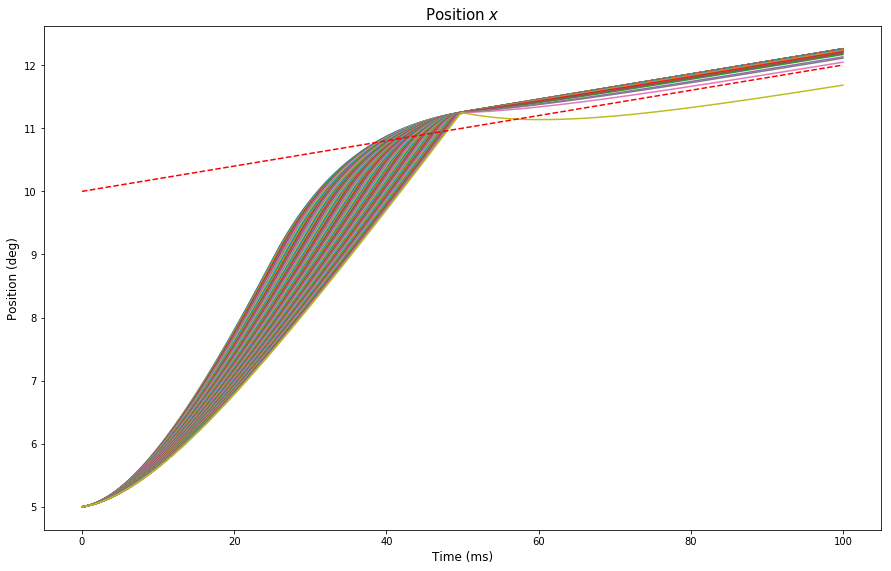

In [21]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
for i in np.arange(n-1):
    ax.plot(time_ms,position[i,:])

ax.set_title('Position $x$', fontsize = 15)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Position (deg)', fontsize=12)
    
ax.plot([0,(t_T+t_R)*1000],[xT,xT+v0*(T+R+1)*dt],'r--')

Text(0,0.5,'Velocity (deg/s)')

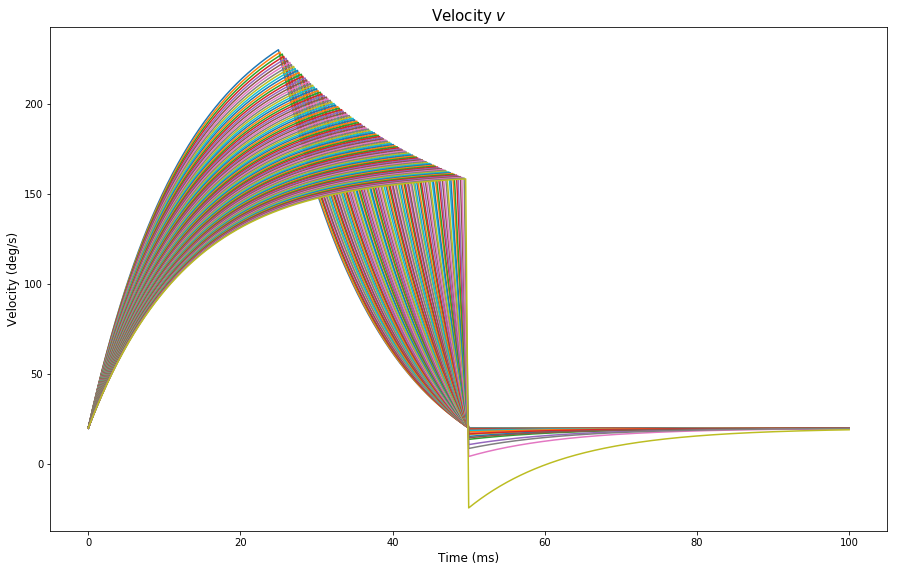

In [22]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
for i in np.arange(n-1):
    ax.plot(time_ms, velocity[i,:])

ax.set_title('Velocity $v$', fontsize = 15)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Velocity (deg/s)', fontsize=12)

# 2. Minimum Variance Theory

Now we want to optimize the movement of the eye using the Minimum Variance Theory developped by Harris and Wolpert (1998).

We will sort out the minimum variance regarding the several solutions of the asymmetrical bang-bang found previously.

## 2.1. Minimum variance

In [23]:
# from the previous results : store all the values of variance of trajectories (variances' functions) in the array somme 
somme = np.zeros(n-1)
for i in np.arange(n-1):
    for j in T+np.arange(R+1):
        somme[i] += variancev[i,j]

In [24]:
# find the minimum variance from the array somme
ind_best = np.argmin(somme)

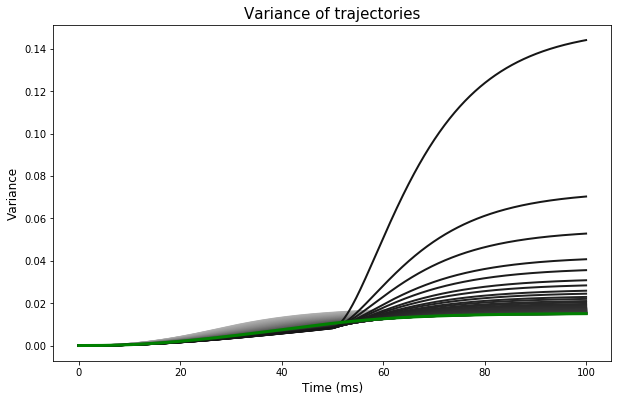

In [25]:
# plot the variance of trajectories and highlight the minimum variance (in green)
fig_width = 10
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
for i in np.arange(n-1):
    ax.plot(time_ms, variancev[i,:]/dt,lw=2,color=(0.7-1.6*i/255,0.7-1.6*i/255,0.7-1.6*i/255))
    ax.set_title(r'Variance of trajectories', fontsize = 15)
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Variance', fontsize=12)
ax.plot(time_ms, variancev[ind_best,:]/dt,lw=3,color='g')

Text(0.73,0.0002,'Best $\\rho$')

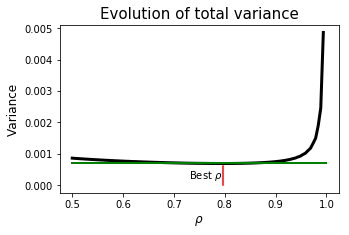

In [26]:
# graphical representation : find the best rho depending on the value of the variance

fig_width = 5
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(rho[0:n-1], somme,lw=3,color=(0,0,0))
ax.set_title(r'Evolution of total variance', fontsize = 15)
ax.set_xlabel(r'$\rho$', fontsize=12)
ax.set_ylabel('Variance', fontsize=12)
ax.plot([0.5,rho[n-1]],[somme[ind_best],somme[ind_best]],lw=2,color='g')
ax.plot([rho[ind_best],rho[ind_best]],[0,0.0006], color='r')
plt.text(0.73,0.0002,r'Best $\rho$', fontsize=10)

In [27]:
# exact value of rho
rho[ind_best]

0.79738383838383831

## 2.2. Graphical representation of asymmetrical bangbang

In the manifold solutions of the asymmetrical bang-bang we found the best solution to optimize the movement of the eye toward a target.

Now with the minimum variance value we can plot the control signal (u), position (x) and velocity (v) according to time.

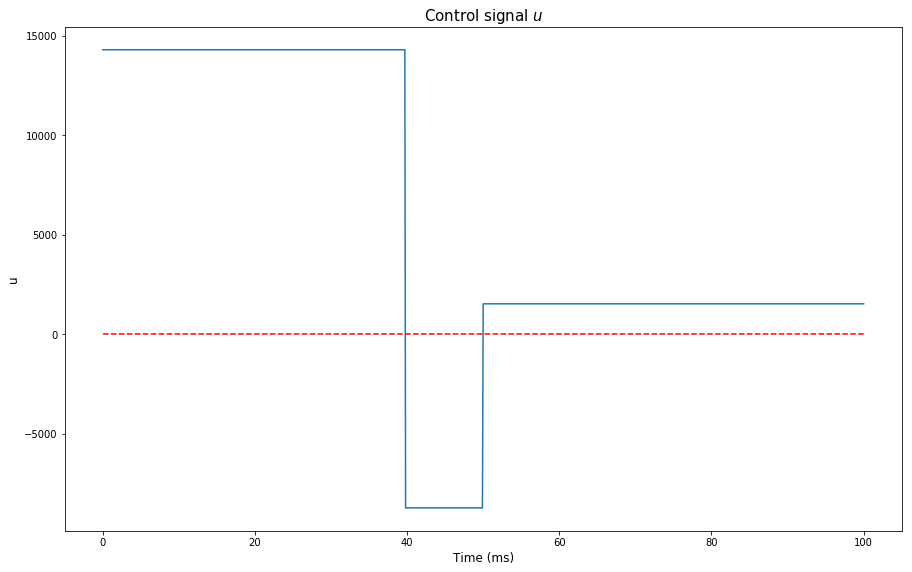

In [28]:
# Asymmetrical bangbang : control signal (u) according to time (in ms)

fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, u[ind_best,:])

ax.set_title('Control signal $u$', fontsize = 15)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('u', fontsize=12)

ax.plot([0,(t_T+t_R)*1000],[0,0],'r--')

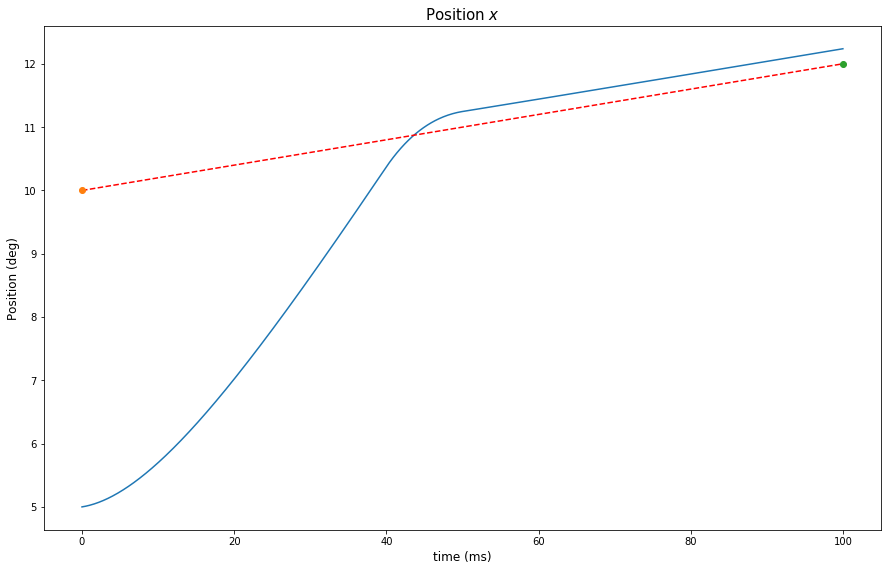

In [29]:
# Asymmetrical bangbang : position (x) according to time (in ms)

fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms,position[ind_best,:])

ax.set_title('Position $x$', fontsize = 15)
ax.set_xlabel('time (ms)', fontsize=12)
ax.set_ylabel('Position (deg)', fontsize=12)

ax.plot([0,(t_T+t_R)*1000],[xT,xT+v0*(T+R+1)*dt],'r--')
ax.plot([0],[xT], marker = 'o')
ax.plot([(t_T+t_R)*1000],[xT+v0*(T+R+1)*dt], marker = 'o')

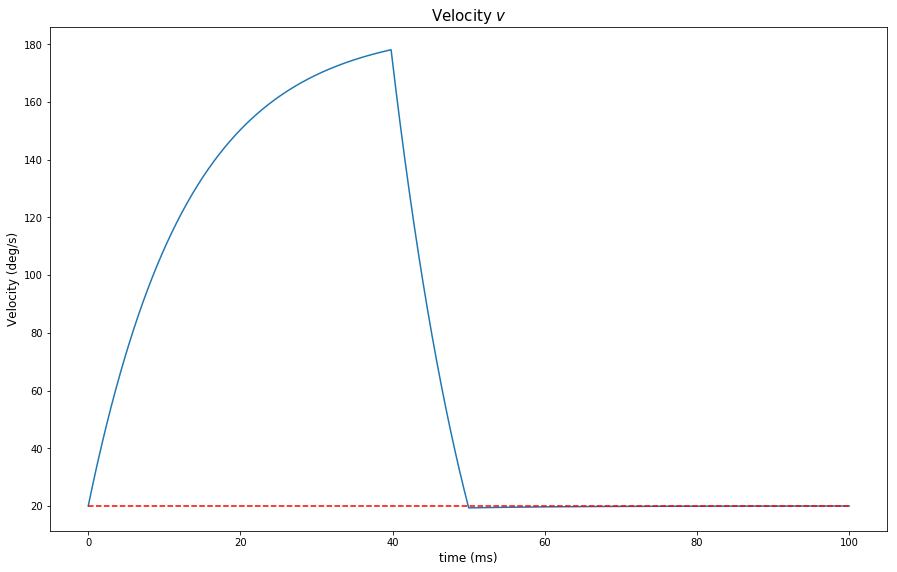

In [30]:
# Asymmetrical bangbang : velocity (v) according to time (in ms)

fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, velocity[ind_best,:])

ax.set_title('Velocity $v$', fontsize = 15)
ax.set_xlabel('time (ms)', fontsize=12)
ax.set_ylabel('Velocity (deg/s)', fontsize=12)

ax.plot([0,(t_T+t_R)*1000],[v0,v0],'r--')

# 4. Generalized coordinates (change title ?)

## 4.1. Definition : linear model for the minimum variance theory
For the **linear models** of the eye and arm, we consider a single-input single-output discrete-time system under control with the following state-update equation:
$$
\tilde{x}_{t+1} = A\tilde{x}_t+B\left (u_t+w_t \right)
$$  
where $\tilde{x}_t$ is the $n$-dimentional state at time $t$, $\tilde{x}_{t+1}$ is the $n$-dimentional state at time $t+dt$, $u_t$ the neural driving signal at time $t$, $w_t$ is a white noise with mean zero and variance $ku_t^2$, $A$ is a fixed $n \times n$ matrix and B is a $n \times 1$ vector both describing the dynamics of the system.

Here, A will be the following matrix:  

$$ A = 
\begin{bmatrix}
1 & dt & \frac{dt^2}{2} & \cdots & \frac{dt^n}{n!}\\
0 & 1 & dt & \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & \vdots\\
0 & 0 & 0 & 1 & dt \\
0 & \cdots & \cdots & \cdots & 1-\frac{dt}{\tau}
\end{bmatrix}
\textbf{ }\textbf{ }\textbf{ }\textbf{ }and\textbf{ }\textbf{ }\textbf{ }\textbf{ }
B = \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \\ dt\end{bmatrix}
$$  
  
We choose this matrix since, according to the Taylor's formula:  
$ x\left (t+dt \right) = x\left (t \right) + dt\times \dot{x}\left (t \right) + \frac{dt^2}{2}\times \ddot{x}\left (t \right)+ \dots + \frac{dt^n}{n!}\times x^{(n)}\left (t \right) + \mathcal{o}\left(dt^n\right)
$
and  
$x^{(n)}\left (t+dt \right) = \left ( 1 - \frac{dt}{\tau} \right)x^{(n)}\left (t \right) + dt\left (u \left (t\right) + w\left (t\right) \right)
$

In [1]:
#TODO: continue...